# Email Classification System - Training Notebook

This notebook performs data preprocessing, EDA, model training, evaluation, and saves trained ML models for the Flask backend.

In [ ]:

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
import sklearn
import pickle
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Harshitha_Yallamati\AppData\Roaming\nltk_data
[nltk_data]     ...
[nltk_data]   Package stopwords is already up-to-date!


: 

## Load Dataset

In [2]:

df = pd.read_csv("enron_dataset.csv")

print("Initial Dataset Preview:")
print(df.head())
print("\nColumns:", df.columns.tolist())


Initial Dataset Preview:
                       file                                            message
0     allen-p/_sent_mail/1.  Message-ID: <18782981.1075855378110.JavaMail.e...
1    allen-p/_sent_mail/10.  Message-ID: <15464986.1075855378456.JavaMail.e...
2   allen-p/_sent_mail/100.  Message-ID: <24216240.1075855687451.JavaMail.e...
3  allen-p/_sent_mail/1000.  Message-ID: <13505866.1075863688222.JavaMail.e...
4  allen-p/_sent_mail/1001.  Message-ID: <30922949.1075863688243.JavaMail.e...

Columns: ['file', 'message']


## Handling Missing Values

In [3]:
print("\n=== INFO (dtypes + non-null + memory) ===")
print(df.info())


=== INFO (dtypes + non-null + memory) ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517401 entries, 0 to 517400
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   file     517401 non-null  object
 1   message  517401 non-null  object
dtypes: object(2)
memory usage: 7.9+ MB
None


In [4]:
print("\n=== Dataset Shape (rows, columns) ===")
print(df.shape)



=== Dataset Shape (rows, columns) ===
(517401, 2)


In [5]:
print("\n=== Null values per column ===")
print(df.isnull().sum())



=== Null values per column ===
file       0
message    0
dtype: int64


## Handling Duplicates

In [6]:
print("\n=== Duplicate Rows Count ===")
print(df.duplicated().sum())

df = df.drop_duplicates()
print("Shape after removing duplicates:", df.shape)



=== Duplicate Rows Count ===
0
Shape after removing duplicates: (517401, 2)


## Outlier-like checks for text


Message length stats:
count    5.174010e+05
mean     2.719685e+03
std      8.360329e+03
min      3.830000e+02
25%      9.020000e+02
50%      1.529000e+03
75%      2.698000e+03
max      2.011941e+06
Name: message_length, dtype: float64


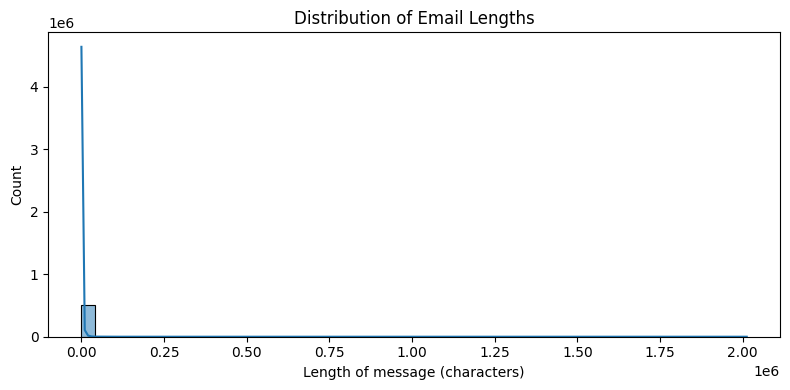

In [7]:
df['message_length'] = df['message'].astype(str).apply(len)

print("\nMessage length stats:")
print(df['message_length'].describe())

# Optional visualization for length distribution
plt.figure(figsize=(8, 4))
sns.histplot(df['message_length'], bins=50, kde=True)
plt.title("Distribution of Email Lengths")
plt.xlabel("Length of message (characters)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## Descriptive Statistics

In [8]:
def auto_label(text):
    text = text.lower()
    if any(word in text for word in ["urgent", "immediately", "action required", "server", "issue"]):
        return "Important"
    elif any(word in text for word in ["offer", "discount", "promotion", "sale"]):
        return "Promotion"
    elif any(word in text for word in ["unsubscribe", "lottery", "win", "free"]):
        return "Spam"
    else:
        return "General"

df['category'] = df['message'].astype(str).apply(auto_label)

print(df[['message', 'category']].head())


                                             message category
0  Message-ID: <18782981.1075855378110.JavaMail.e...  General
1  Message-ID: <15464986.1075855378456.JavaMail.e...  General
2  Message-ID: <24216240.1075855687451.JavaMail.e...  General
3  Message-ID: <13505866.1075863688222.JavaMail.e...  General
4  Message-ID: <30922949.1075863688243.JavaMail.e...  General


In [9]:
print("\n=== Descriptive Statistics for message_length ===")
print(df['message_length'].describe())

print("\n=== Value Counts for 'category' Column ===")
print(df['category'].value_counts())



=== Descriptive Statistics for message_length ===
count    5.174010e+05
mean     2.719685e+03
std      8.360329e+03
min      3.830000e+02
25%      9.020000e+02
50%      1.529000e+03
75%      2.698000e+03
max      2.011941e+06
Name: message_length, dtype: float64

=== Value Counts for 'category' Column ===
category
General      285013
Important     91706
Spam          81876
Promotion     58806
Name: count, dtype: int64


## Visual Analysis

C:\Users\Harshitha_Yallamati\AppData\Local\Temp\ipykernel_44860\863873533.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='category', data=df,


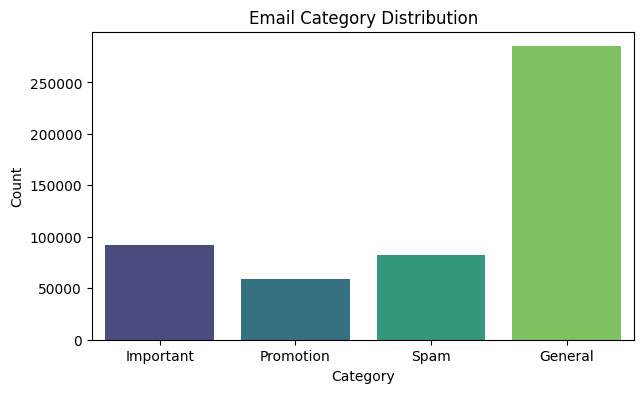

In [10]:
plt.figure(figsize=(7, 4))
sns.countplot(x='category', data=df,
              order=['Important', 'Promotion', 'Spam', 'General'],
              palette="viridis")
plt.title("Email Category Distribution")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()


Histogram already plotted above (message length)

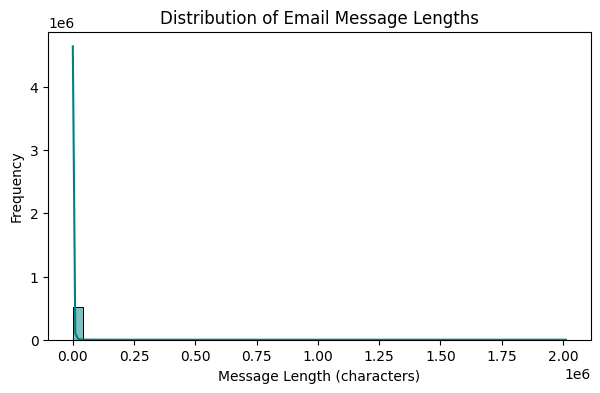

In [11]:
plt.figure(figsize=(7, 4))
sns.histplot(df['message_length'], bins=50, kde=True, color="teal")
plt.title("Distribution of Email Message Lengths")
plt.xlabel("Message Length (characters)")
plt.ylabel("Frequency")
plt.show()


## Activity 2.3 / 2.4: Univariate & Bivariate Analysis


Category value counts:
category
General      272842
Spam         153199
Promotion     72922
Important     18438
Name: count, dtype: int64


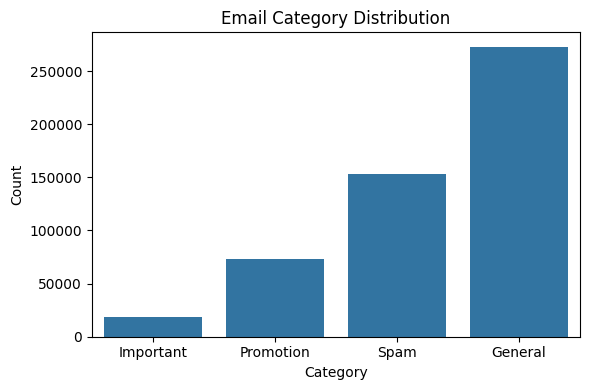

In [12]:
def auto_label_category(text: str) -> str:
    t = text.lower()

    # Spam
    if any(word in t for word in [
        "free", "win", "winner", "prize", "click here",
        "claim now", "lottery", "reward"
    ]):
        return "Spam"

    # Promotion
    if any(word in t for word in [
        "offer", "discount", "sale", "deal",
        "buy now", "limited time", "subscribe",
        "promotion", "we go live", "connect your"
    ]):
        return "Promotion"

    # Important
    if any(word in t for word in [
        "urgent", "immediate", "asap",
        "server is down", "security alert",
        "outage", "critical", "requires immediate attention"
    ]):
        return "Important"

    # General (default)
    return "General"


df['category'] = df['message'].astype(str).apply(auto_label_category)

print("\nCategory value counts:")
print(df['category'].value_counts())

plt.figure(figsize=(6, 4))
sns.countplot(x='category', data=df,
              order=['Important', 'Promotion', 'Spam', 'General'])
plt.title("Email Category Distribution")
plt.xlabel("Category")
plt.ylabel("Count")
plt.tight_layout()
plt.show()



C:\Users\Harshitha_Yallamati\AppData\Local\Temp\ipykernel_44860\3858883644.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='category', data=df, palette="viridis")


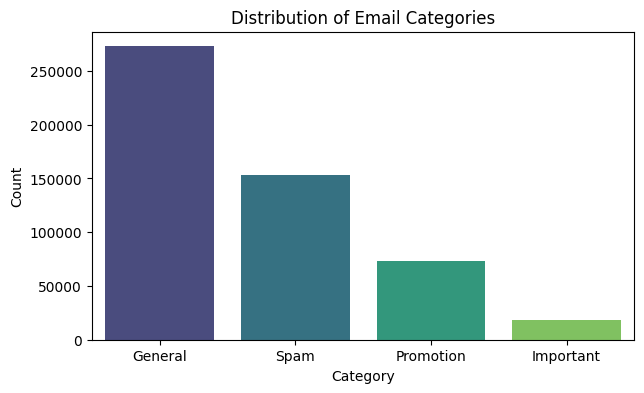

In [13]:
plt.figure(figsize=(7, 4))
sns.countplot(x='category', data=df, palette="viridis")
plt.title("Distribution of Email Categories")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()


C:\Users\Harshitha_Yallamati\AppData\Local\Temp\ipykernel_44860\1347670906.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='category', data=df, palette="viridis")


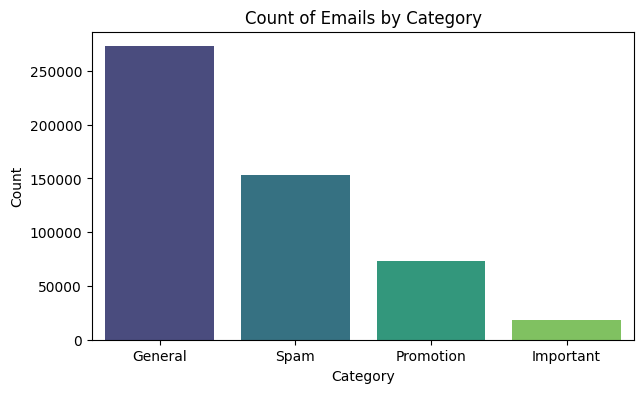

In [14]:
plt.figure(figsize=(7, 4))
sns.countplot(x='category', data=df, palette="viridis")
plt.title("Count of Emails by Category")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()


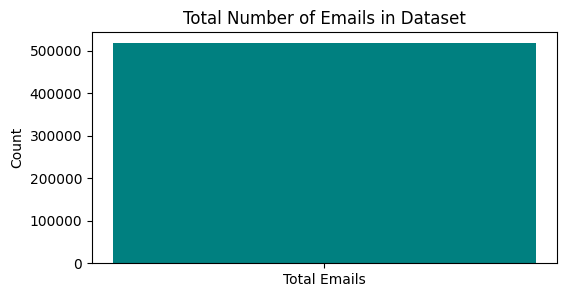

In [15]:
plt.figure(figsize=(6, 3))
plt.bar(['Total Emails'], [len(df)], color='teal')
plt.title("Total Number of Emails in Dataset")
plt.ylabel("Count")
plt.show()


In [16]:
plt.figure(figsize=(7, 4))
sns.histplot(df['word_count'], kde=True, bins=50, color='orange')
plt.title("Distribution of Email Word Count")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()


KeyError: 'word_count'

<Figure size 700x400 with 0 Axes>

## Activity 2.5 / 2.6: Correlation & Pairplot (on numeric features)

In [ ]:
df['word_count'] = df['clean_message'].apply(lambda x: len(x.split()))
df['avg_word_length'] = df['clean_message'].apply(
    lambda x: np.mean([len(word) for word in x.split()]) if x.split() else 0
)

numeric_cols = ['message_length', 'word_count', 'avg_word_length']
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Email Features")
plt.show()


In [ ]:
# Create additional numerical features
df['word_count'] = df['clean_message'].apply(lambda x: len(x.split()))
df['avg_word_length'] = df['clean_message'].apply(
    lambda x: np.mean([len(word) for word in x.split()]) if x.split() else 0
)

numeric_features = ['message_length', 'word_count', 'avg_word_length', 'category']

pairplot_df = df[numeric_features]
sns.pairplot(pairplot_df, hue='category',
             vars=['message_length', 'word_count', 'avg_word_length'],
             palette="Set2")

## 2.7: Feature Extraction (TF-IDF instead of scaling)

In [ ]:
N_SAMPLES = 5000
if len(df) > N_SAMPLES:
    df = df.sample(N_SAMPLES, random_state=42)
    print(f"\nSubsampled dataset to {N_SAMPLES} rows for faster training.")

# Custom text cleaner
def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    tokens = [
        token for token in text.split()
        if token not in stop_words and len(token) > 2
    ]
    return " ".join(tokens)

df['clean_message'] = df['message'].astype(str).apply(clean_text)

tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['clean_message'])
y = df['category']

print("\nTF-IDF shape:", X.shape)



## Activity 2.8: Train-Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nTrain shape:", X_train.shape)
print("Test shape:", X_test.shape)

## Milestone 3: Model Building

In [ ]:
import re

def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    tokens = [
        token for token in text.split()
        if token not in stop_words and len(token) > 2
    ]
    return " ".join(tokens)

df['clean_message'] = df['message'].astype(str).apply(clean_text)

print(df[['message', 'clean_message']].head())

def auto_label(text):
    text = text.lower()
    if any(word in text for word in ["urgent", "immediately", "action required"]):
        return "Important"
    elif any(word in text for word in ["offer", "discount", "sale"]):
        return "Promotion"
    elif any(word in text for word in ["unsubscribe", "lottery", "win"]):
        return "Spam"
    else:
        return "General"

df['category'] = df['message'].astype(str).apply(auto_label)


In [ ]:
# --- IMPORTS ---
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import pandas as pd

# --- TRAIN/TEST SPLIT ---
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_message'],
    df['category'],
    test_size=0.2,
    random_state=42,
    stratify=df['category']
)

# --- PIPELINES FOR EACH MODEL ---
pipelines = {
    "Logistic Regression": Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000)),
        ('clf', LogisticRegression(max_iter=1000))
    ]),
    
    "Multinomial NB": Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000)),
        ('clf', MultinomialNB())
    ]),
    
    "Decision Tree": Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000)),
        ('clf', DecisionTreeClassifier())
    ]),
    
    "Random Forest": Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000)),
        ('clf', RandomForestClassifier(n_estimators=100))
    ]),
    
    "Linear SVM": Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000)),
        ('clf', LinearSVC())
    ]),
    
    "KNN": Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000)),
        ('clf', KNeighborsClassifier(n_neighbors=5))
    ])
}

# --- MODEL TRAINING & EVALUATION ---
results = []

for name, model in pipelines.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    results.append((name, acc))
    print(f"{name} Accuracy: {acc:.4f}")

# --- RESULTS TABLE ---
results_df = pd.DataFrame(results, columns=["Model", "Accuracy"])
results_df = results_df.sort_values(by="Accuracy", ascending=False)

print("\n=== Model Comparison (TF-IDF + Classifier) ===")
print(results_df)


In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Multinomial NB": MultinomialNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Linear SVM": LinearSVC(),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

model_results = []

for name, clf in models.items():
    print(f"\nTraining {name}...")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    model_results.append((name, acc))
    print(f"{name} Accuracy: {acc:.4f}")

# Convert results to DataFrame
results_df = pd.DataFrame(model_results, columns=["Model", "Accuracy"])
print("\n=== Model Comparison ===")
print(results_df.sort_values(by="Accuracy", ascending=False))


## Milestone 4: Performance Testing & Selection

In [ ]:
best_model_name = results_df.sort_values(
    by="Accuracy", ascending=False
).iloc[0]["Model"]

print(f"\nBest Model based on accuracy: {best_model_name}")

best_model = models[best_model_name]

# Detailed metrics for best model
y_best_pred = best_model.predict(X_test)
print("\n=== Classification Report (Best Model) ===")
print(classification_report(y_test, y_best_pred))

print("\n=== Confusion Matrix (Best Model) ===")
cm = confusion_matrix(y_test, y_best_pred,
                      labels=['Important', 'Promotion', 'Spam', 'General'])
print(cm)

plt.figure(figsize=(6, 4))
sns.heatmap(cm,
            annot=True,
            fmt="d",
            xticklabels=['Important', 'Promotion', 'Spam', 'General'],
            yticklabels=['Important', 'Promotion', 'Spam', 'General'],
            cmap="Blues")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()



## Milestone 5: Model Deployment Artifacts

In [ ]:
final_model = models["Logistic Regression"]

# Retrain Logistic Regression on full data (X, y)
print("\nRetraining Logistic Regression on full dataset...")
final_model.fit(X, y)

# Save model and vectorizer
with open("logistic_model.pkl", "wb") as f:
    pickle.dump(final_model, f)

with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)

print("\n✅ Saved logistic_model.pkl and tfidf_vectorizer.pkl successfully.")
print("These can now be used in your Flask backend (app.py).")


## Train-Test Split

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(X_train.shape, X_test.shape)


## Model Training & Comparison

In [ ]:

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Linear SVM": LinearSVC(),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    results.append((name, acc))
    print(f"{name} Accuracy: {acc:.4f}")

results_df = pd.DataFrame(results, columns=["Model", "Accuracy"])
print(results_df)


## Save Final Model & Vectorizer

In [ ]:

final_model = models["Logistic Regression"]
final_model.fit(X, y)

with open("logistic_model.pkl", "wb") as f:
    pickle.dump(final_model, f)

with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)

print("Model and Vectorizer saved successfully!")
